In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf
import pandas as pd

### Reading and preprocessing data

We must read, normalize, reshape, and preprocess our data in order to make sure that our model can train on it effectivley.

In [2]:
train = pd.read_csv("../input/mnist-in-csv/mnist_train.csv").dropna()
train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X = train.drop("label", axis=1)
y = train["label"]

X = np.array(X)
y = np.array(y)

X = X/ 255.

X = X.reshape(-1, 28, 28, 1)

In [4]:
X.shape, y.shape

((60000, 28, 28, 1), (60000,))

### Visualizing

In order to visualize our dataset, we can randomly display an image from the dataset.

8


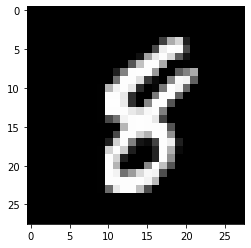

In [5]:
import random 
def display_random_image(dataset, length, width=28, height=28):
    index = random.randint(0, length-1)
    current_image = dataset.drop("label", axis=1).iloc[index].to_numpy()
    current_image = current_image.reshape((width, height))
    label = dataset["label"].iloc[index]
    print(label)
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()
    
display_random_image(train, 60000)

### Training
We will be using an autoencoder. An autoencoder isn't like most neural networks. Most neural networks, predict. But, this neural network will learn how to convert its input image to lower dimensions and get the input image back as the output. In other words, the target output is the input. There are many purposes of this neural network. Some applications can be anomaly detection and reducing dimensionality so that we can make our code run much faster.

In [6]:
tf.random.set_seed(42)

encoder_input = tf.keras.Input(shape=(28, 28, 1), name='img')
x = tf.keras.layers.Flatten()(encoder_input)
encoder_output = tf.keras.layers.Dense(64, activation="relu")(x)

encoder = tf.keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = tf.keras.layers.Dense(64, activation="relu")(encoder_output)
x = tf.keras.layers.Dense(784, activation="relu")(decoder_input)
decoder_output = tf.keras.layers.Reshape((28, 28, 1))(x)

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

autoencoder = tf.keras.models.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

autoencoder.compile(opt, loss='mse')

history = autoencoder.fit(X, X, epochs=10, batch_size=32, validation_split=0.10) 

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               50960     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 105,360
Trainable params: 105,360
Non-trainable params: 0
_________________________________________________

### Preprocessing Test Data
Now, in order to test our model, we will have to make sure our test data is in the same format as the training data.

In [7]:
test = pd.read_csv("../input/mnist-in-csv/mnist_train.csv").dropna()
test.head()

X_test = test.drop("label", axis=1)
y_test = test["label"]

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test/ 255.

X = X.reshape(-1, 28, 28, 1)

### Encoding an image
We are going to encode an image from the dataset. We will be using the encoder network. The original dimensions of our input is 28x28. The encoded image with be 8x8.

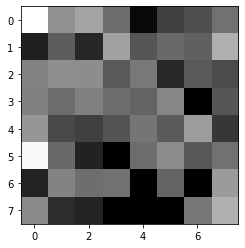

In [8]:
example = np.array(tf.squeeze(encoder.predict([X_test[0].reshape(-1, 28, 28, 1)])))
plt.imshow(example.reshape((8,8)), cmap="gray")

### Using the autoencoder
Now, we want to see the results of the autoencoder. So, we will compare the original image to the reconstruced image. On the left is the reconstructed, and on the right is the actual image. This is really good and our autoencoder does really well with reconstrucing our images!

Number: 5


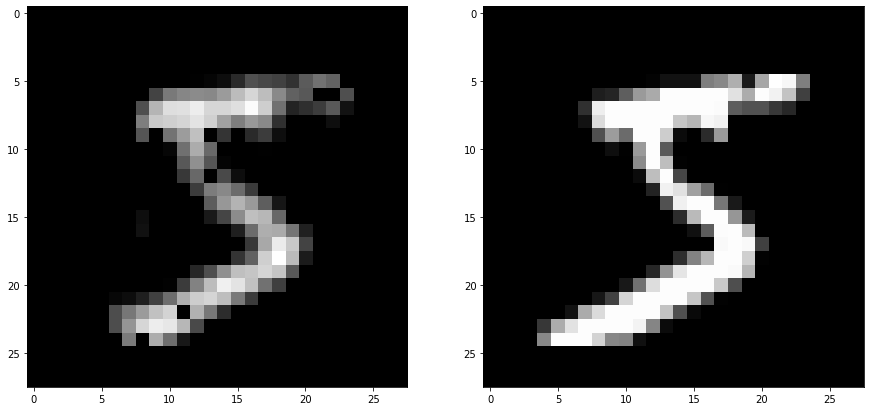

In [14]:
ae_out = autoencoder.predict([X_test[0].reshape(-1, 28, 28, 1)])
ae_out = tf.squeeze(ae_out)
print(f"Number: {y_test[0]}")
predicted_image = ae_out
actual_image = X_test[0].reshape(28, 28, 1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2,1)
plt.imshow(predicted_image, cmap="gray")
plt.subplot(1,2, 2)
plt.imshow(actual_image, cmap="gray")